In [1]:
%pip install librosa matplotlib scikit-learn tensorflow


Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [1]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def extract_mel_spectrogram(file_path, n_mels=128):
    import librosa
    y, sr = librosa.load(file_path, sr=16000)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db

def load_data_from_folders(base_path):
    data = []
    labels = []
    label_map = {'real': 0, 'fake': 1}

    for subset in ['train', 'dev', 'eval']:
        for label in ['real', 'fake']:
            folder_path = os.path.join(base_path, subset, label)#form-norm/train/real 
            if not os.path.exists(folder_path):
                print(f"❌ Folder not found: {folder_path}")
                continue

            count = 0
            for file in os.listdir(folder_path):
                if file.endswith('.wav'):
                    file_path = os.path.join(folder_path, file)#form-norm/train/real
                    try:
                        mel = extract_mel_spectrogram(file_path)
                        if mel.shape[1] < 128:
                            continue
                        mel = mel[:, :128]  # Resize to fixed width
                        data.append(mel)
                        labels.append(label_map[label])
                        count += 1
                    except Exception as e:
                        print(f"⚠️ Error loading {file}: {e}")
            print(f"✅ Loaded {count} from {subset}/{label}")

    return np.array(data), np.array(labels)

base_path = 'for-norm'  # Change this if needed (like 'data/for-norm')
X, y = load_data_from_folders(base_path)


X = X.reshape((X.shape[0], 128, 128, 1)) / 255.0

# ✅ One-hot encode labels
y_cat = to_categorical(y, 2)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)
print(X_train)
print("✅ Data loaded and preprocessed successfully!")
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)



✅ Loaded 534 from train/real
✅ Loaded 2236 from train/fake
✅ Loaded 704 from dev/real
✅ Loaded 2361 from dev/fake
✅ Loaded 1337 from eval/real
✅ Loaded 5534 from eval/fake
[[[[-0.08650441]
   [-0.07329764]
   [-0.08652869]
   ...
   [-0.07796098]
   [-0.06589854]
   [-0.06041194]]

  [[-0.0799869 ]
   [-0.06708506]
   [-0.06709117]
   ...
   [-0.09182618]
   [-0.06150561]
   [-0.06175338]]

  [[-0.07123151]
   [-0.06536939]
   [-0.06939265]
   ...
   [-0.08843831]
   [-0.07577854]
   [-0.07327653]]

  ...

  [[-0.27002612]
   [-0.258785  ]
   [-0.26164797]
   ...
   [-0.27495763]
   [-0.27336028]
   [-0.2723114 ]]

  [[-0.28787738]
   [-0.2820625 ]
   [-0.28182766]
   ...
   [-0.29542163]
   [-0.30296403]
   [-0.29928127]]

  [[-0.3137255 ]
   [-0.31225702]
   [-0.3137255 ]
   ...
   [-0.29552975]
   [-0.30870584]
   [-0.3137255 ]]]


 [[[-0.17984763]
   [-0.15998444]
   [-0.13307099]
   ...
   [-0.12025125]
   [-0.13948539]
   [-0.12499844]]

  [[-0.12820265]
   [-0.10408346]
   [-0.0

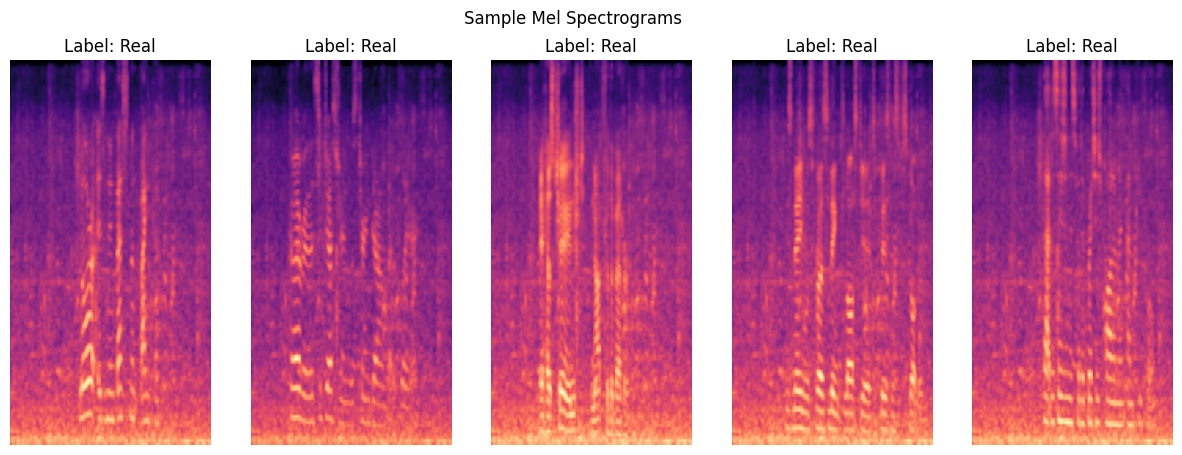

In [7]:
import matplotlib.pyplot as plt

# Reverse one-hot labels
y_labels = np.argmax(y_cat, axis=1)

# Class map
class_names = ['Real', 'Fake']

# Plot 5 random samples
def show_sample_spectrograms(X, y_labels, class_names, num=5):
    plt.figure(figsize=(15, 5))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.imshow(X[i].squeeze(), aspect='auto', origin='lower', cmap='magma')
        plt.title(f"Label: {class_names[y_labels[i]]}")
        plt.axis('off')
    plt.suptitle("Sample Mel Spectrograms")
    plt.show()

# Call the function
show_sample_spectrograms(X, y_labels, class_names, num=5)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense (Dense)               (None, 128)               7

In [9]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
255/255 [==============================] - 127s 491ms/step - loss: 0.4681 - accuracy: 0.8011 - val_loss: 0.3173 - val_accuracy: 0.8637
Epoch 2/10
255/255 [==============================] - 106s 416ms/step - loss: 0.1727 - accuracy: 0.9353 - val_loss: 0.0875 - val_accuracy: 0.9759
Epoch 3/10
255/255 [==============================] - 204s 801ms/step - loss: 0.0541 - accuracy: 0.9829 - val_loss: 0.0716 - val_accuracy: 0.9725
Epoch 4/10
255/255 [==============================] - 127s 497ms/step - loss: 0.0258 - accuracy: 0.9932 - val_loss: 0.0084 - val_accuracy: 0.9980
Epoch 5/10
255/255 [==============================] - 181s 711ms/step - loss: 0.0193 - accuracy: 0.9940 - val_loss: 0.0382 - val_accuracy: 0.9887
Epoch 6/10
255/255 [==============================] - 194s 761ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.0136 - val_accuracy: 0.9956
Epoch 7/10
255/255 [==============================] - 301s 1s/step - loss: 0.0070 - accuracy: 0.9984 - val_loss: 0.0040 - va

In [10]:
# Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy * 100:.2f}%")

# Save model
model.save("audio_deepfake_cnn.h5")


80/80 [==============================] - 14s 179ms/step - loss: 0.0022 - accuracy: 0.9992

✅ Test Accuracy: 99.92%


c:\Users\Megha\MLProject2\vfenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


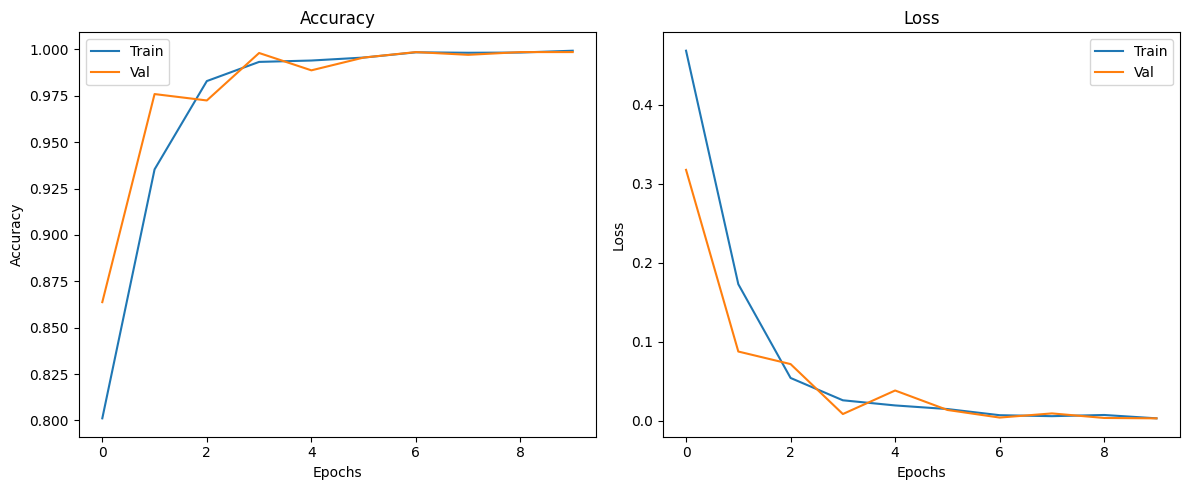

In [11]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

